# Axis Capital - Data Preprocessing

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
import PyPDF2, os, re, pickle
from tika import parser
import textstat
import pandas as pd

import spacy
nlp = spacy.load('en')

In [6]:
# settings
HOMEDIR = r'E:\Clients\axiscapitalstockrecom'
DATADIR = r'E:\Clients\axiscapitalstockrecom\data'
RESULTSDIR = r'E:\Clients\axiscapitalstockrecom\results'

In [7]:
all_data_pkl = open(os.path.join(RESULTSDIR,'processed_files','AllDataPickle'), 'rb')
data,files_dict,transcripts,df,companies_info,features,summaries,NER_Output,readbility = pickle.load(all_data_pkl)
all_data_pkl.close()

In [10]:
print(data.columns)
print(transcripts.columns)
print(df.columns)
print(companies_info.columns)
print(features.columns)
print(summaries.columns)
print(NER_Output.columns)
print(readbility.columns)

Index(['CompanyCurrentYQ', 'Company', 'FileName', 'text', 'NumberChars',
       'CompanyName', 'FolderName', 'YQ', 'Y', 'Q', 'FY_CY', 'CompanyCode',
       'MoneyControlCompanyCode', 'FullPath', 'MCapRank', 'NQ', 'NY',
       'CompanyNextYQ', 'CompanyYQ_x', 'value_x', 'CompanyYQ_y', 'value_y'],
      dtype='object')
Index(['Company', 'FileName', 'text', 'NumberChars'], dtype='object')
Index(['MoneyControlCompanyCode', 'type', 'property', 'quarter', 'value', 'Q',
       'Y', 'CompanyYQ'],
      dtype='object')
Index(['CompanyName', 'FolderName', 'FileName', 'YQ', 'Y', 'Q', 'FY_CY',
       'CompanyCode', 'MoneyControlCompanyCode', 'FullPath', 'MCapRank'],
      dtype='object')
Index(['CompanyCurrentYQ', 'text', 'value_x', 'value_y', 'word_count',
       'char_count', 'avg_word', 'numerics', 'PctChng', 'NER_CARDINAL',
       'NER_DATE', 'NER_GPE', 'NER_LOC', 'NER_MONEY', 'NER_NORP',
       'NER_ORDINAL', 'NER_ORG', 'NER_PERCENT', 'NER_PERSON', 'NER_QUANTITY',
       'NER_TIME', 'NER_EVENT

#load previous session
p_transcripts = open(os.path.join(RESULTSDIR,'processed_files','transcripts','transcriptsPickle'), 'rb')
transcripts = pickle.load(p_transcripts)
p_transcripts.close()

p_pdfs = open(os.path.join(RESULTSDIR,'processed_files','transcripts','PDFsPickle'), 'rb')
files_dict = pickle.load(p_pdfs)
p_pdfs.close()

p_financials = open(os.path.join(RESULTSDIR,'processed_files','financialsPickle'), 'rb')
df = pickle.load(p_financials)
p_financials.close()

p_meta = open(os.path.join(RESULTSDIR,'processed_files','metadataPickle'), 'rb')
companies_info = pickle.load(p_meta)
p_meta.close()

p_features = open(os.path.join(RESULTSDIR,'processed_files','featuresPickle'), 'rb')
features = pickle.load(p_features)
p_features.close()

# Metadata

In [5]:
companies_info = pd.read_excel(r"../data/metadata/Transcripts.xlsx")

In [6]:
print(companies_info.columns)
print(companies_info.shape)
companies_info.head()

Index(['CompanyName', 'FolderName', 'FileName', 'YQ', 'Y', 'Q', 'FY_CY',
       'CompanyCode', 'MoneyControlCompanyCode', 'FullPath', 'MCapRank'],
      dtype='object')
(1719, 11)


,CompanyName,FolderName,FileName,YQ,Y,Q,FY_CY,CompanyCode,MoneyControlCompanyCode,FullPath,MCapRank
0,ABB India Ltd.,abb,FY11Q12011-q1_analyst-call-transcript.pdf,FY11Q1,2011,1,FY,abb,ABB,E:\Clients\axiscapitalstockrecom\data\transcri...,96
1,ABB India Ltd.,abb,FY11Q22011-q2-analyst-call.pdf,FY11Q2,2011,2,FY,abb,ABB,E:\Clients\axiscapitalstockrecom\data\transcri...,96
2,ABB India Ltd.,abb,FY11Q32011-q3-analyst-call.pdf,FY11Q3,2011,3,FY,abb,ABB,E:\Clients\axiscapitalstockrecom\data\transcri...,96
3,ABB India Ltd.,abb,FY11Q42011-q4-analyst_call.pdf,FY11Q4,2011,4,FY,abb,ABB,E:\Clients\axiscapitalstockrecom\data\transcri...,96
4,ABB India Ltd.,abb,FY12Q1q1-2012-analyst-transcript.pdf,FY12Q1,2012,1,FY,abb,ABB,E:\Clients\axiscapitalstockrecom\data\transcri...,96


# Financials

### Import Data

In [7]:
df = pd.read_csv(r"../data/financials/moneycontrol/results/results20190828.csv")
df.columns = ["MoneyControlCompanyCode","type","property","quarter","value"]

### Sanity Checks

In [8]:
print(df.columns)
print(df.shape)
df.head()

Index(['MoneyControlCompanyCode', 'type', 'property', 'quarter', 'value'], dtype='object')
(405953, 5)


,MoneyControlCompanyCode,type,property,quarter,value
0,HDF01,profit,,Mar '19,12 mths
1,HDF01,profit,Interest Earned,Mar '19,"98,972.05"
2,HDF01,profit,Other Income,Mar '19,"17,625.88"
3,HDF01,profit,Interest expended,Mar '19,"50,728.83"
4,HDF01,profit,Employee Cost,Mar '19,"7,761.76"


### Corrections and Filters

In [9]:
df = df.loc[(df['value'] != '12 mths') &
            (df['value'] != '--') &
            ~df['value'].str.contains("mths")]

df['value'] = (df['value'].replace(',','', regex=True).astype(float))
print(df.shape)
df.head()

(236355, 5)


,MoneyControlCompanyCode,type,property,quarter,value
1,HDF01,profit,Interest Earned,Mar '19,98972.05
2,HDF01,profit,Other Income,Mar '19,17625.88
3,HDF01,profit,Interest expended,Mar '19,50728.83
4,HDF01,profit,Employee Cost,Mar '19,7761.76
5,HDF01,profit,"Selling, Admin & Misc Expenses",Mar '19,35889.08


In [10]:
q_dict = {'Mar':4,'Jun':1,'Dec':3,'Sep':2,'Jul':0,'Apr':0,'Jan':0,'Oct':0}

In [11]:
df['Q'] = [q_dict[x] for x in df.quarter.str.slice(0,3)]
df['Y'] = [int('19'+x) if int(x)>50 else int('20'+x) for x in df.quarter.str.slice(5,7)]

In [12]:
df.head()

,MoneyControlCompanyCode,type,property,quarter,value,Q,Y
1,HDF01,profit,Interest Earned,Mar '19,98972.05,4,2019
2,HDF01,profit,Other Income,Mar '19,17625.88,4,2019
3,HDF01,profit,Interest expended,Mar '19,50728.83,4,2019
4,HDF01,profit,Employee Cost,Mar '19,7761.76,4,2019
5,HDF01,profit,"Selling, Admin & Misc Expenses",Mar '19,35889.08,4,2019


# Transcripts

In [13]:
file_list = ['../data/transcripts/companies/'+k+'/'+f for k in os.listdir('../data/transcripts/companies/') for f in os.listdir('../data/transcripts/companies/'+k)]

In [14]:
file_names = [f.split("/")[-1] for f in file_list]
company_names = [f.split("/")[-2] for f in file_list]

In [15]:
def tika_parser(file_path):
    # Extract text from document
    content = parser.from_file(file_path)
    if 'content' in content:
        text = content['content']
    else:
        return
    # Convert to string
    text = str(text)
    # Ensure text is utf-8 formatted
    safe_text = text.encode('utf-8', errors='ignore')
    # Escape any \ issues
    safe_text = str(safe_text).replace('\\', '\\\\').replace('"', '\\"')
    return safe_text

In [16]:
#%%time
#files = []
#files_dict = {}
#
#complete_files = []
#errors_files = []
#
#for i in range(len(file_list)):#range(20):
#    f = file_list[i]
#    try:
#        parsedPDF = parser.from_file(f)
#        texts = parsedPDF["content"]
#        file_name = f.split("/")[-1]
#        texts = str(texts).replace('\n',' ')
#        texts = re.sub('\s+', ' ', texts).strip()
#        with open('../results/processed_files/transcripts/'+file_name.replace('pdf','')+'txt','w+', encoding='utf-8') as file1:
#            file1.write(texts)
#        files_dict[i] = {
#                "Company":company_names[i],
#                "FileName":file_names[i],
#                "text": texts
#            }
#        complete_files.append(f)
#    except:
#        print(f+' incomplete..')
#        errors_files.append(f)
#        continue
#
#print("Total Files :", len(complete_files) + len(errors_files))
#print("Files processed :", len(complete_files))
#print("Files not processed :", len(errors_files))

In [17]:
transcripts = pd.DataFrame([v for k,v in files_dict.items()])
transcripts.head()

,Company,FileName,text
0,abb,FY11Q12011-q1_analyst-call-transcript.pdf,ABB Limited First Quarter Results Conference C...
1,abb,FY11Q22011-q2-analyst-call.pdf,Transcript Page 1 Transcript Conference Call o...
2,abb,FY11Q32011-q3-analyst-call.pdf,Page 1 Transcript - Conference Call of ABB Lim...
3,abb,FY11Q42011-q4-analyst_call.pdf,Page 1 of 16 “ABB Ltd’s Investor Relations & M...
4,abb,FY12Q1q1-2012-analyst-transcript.pdf,“TCS Second Quarter Earnings Conference Call” ...


In [18]:
transcripts['NumberChars'] = transcripts.text.apply(len)

In [19]:
transcripts.sort_values(["NumberChars"])

,Company,FileName,text,NumberChars
278,containercorporationofindia,Q1FY20 POST Result Conference Call of Containe...,Q1FY20 POST Result Conference Call of Containe...,480
157,bharatheavyelectricals,BHEL Q1FY20 Results Institutional Investor Ana...,AA:PLD:56::050819 BHEL: Q1FY20 Results (Instit...,569
1352,tatamotors,FY12Q2results-concall-transcript-JLR-Q2-FY12.pdf,Microsoft Word - Concall invite - Jaguar LandR...,881
160,bharatheavyelectricals,BHEL Q3FY19 Results Institutional Investor Ana...,Microsoft Word - Q4&FY16 Conf Call Notice-1.do...,951
159,bharatheavyelectricals,BHEL Q2FY19 Results Institutional Investor Ana...,Microsoft Word - Q4&FY16 Conf Call Notice-1.do...,962
...,...,...,...,...
577,hindustanunilever,CY12Q4dq12transcript_tcm1255-435714_en.pdf,HUL earnings call 2013 Page 1 of 48 “December ...,100439
596,hindustanunilever,CY17Q3sq-2017-results-transcript_tcm1255-51159...,HUL Earnings call transcript September Quarter...,105058
594,hindustanunilever,CY17Q1mq-2017-results-transcript_tcm1255-50447...,March Quarter 2017 Earnings Call March Quarter...,108648
365,eichermotors,Eicher-Q4CY11.pdf,Microsoft Word - EmkayGlobal-EicherMotors-13Fe...,111204


In [20]:
# Check if text level dedupe is required
print(transcripts.shape)
print(len(set(transcripts.text)))
print(len(set(transcripts.FileName)))
print(len(set(transcripts.Company + transcripts.text)))

(1714, 4)
1696
1714
1696


### Red flag companies:
    1.Zee (Not available as text in some PDF; Only header and footer extractable)
    2.BHEL (Invites Only)
    3.Container Corporation Of India (Invite Only)
    4.Grasim (Invite Only)
    5.Hindustan Lever (Calendar Year Based)
    6.Tata Motors (Some of the transcripts are just invites)

Hence choosing a text length threshold of 3000 characters for sanity purposes

In [21]:
transcripts = transcripts.loc[transcripts["NumberChars"]>3000]
print(transcripts.shape)

(1699, 4)


In [22]:
# Dedupe needed
transcripts.drop_duplicates(subset="text",inplace=True, keep=False)
print(transcripts.shape)

(1663, 4)


In [23]:
transcripts.head()

,Company,FileName,text,NumberChars
0,abb,FY11Q12011-q1_analyst-call-transcript.pdf,ABB Limited First Quarter Results Conference C...,42233
1,abb,FY11Q22011-q2-analyst-call.pdf,Transcript Page 1 Transcript Conference Call o...,43820
2,abb,FY11Q32011-q3-analyst-call.pdf,Page 1 Transcript - Conference Call of ABB Lim...,49583
3,abb,FY11Q42011-q4-analyst_call.pdf,Page 1 of 16 “ABB Ltd’s Investor Relations & M...,44992
4,abb,FY12Q1q1-2012-analyst-transcript.pdf,“TCS Second Quarter Earnings Conference Call” ...,44788


In [24]:
#transcripts[["Company","FileName","NumberChars"]].to_csv(os.path.join(RESULTSDIR,"transcripts_details.csv"), index = False)
#df.to_csv(os.path.join(RESULTSDIR,"financials_details.csv"), index = False)

# Merge datasets

In [25]:
print("Financials -----> ",df.columns)
print("Transcripts -----> ",transcripts.columns)
print("CompaniesMetaData -----> ",companies_info.columns)

Financials ----->  Index(['MoneyControlCompanyCode', 'type', 'property', 'quarter', 'value', 'Q',
       'Y'],
      dtype='object')
Transcripts ----->  Index(['Company', 'FileName', 'text', 'NumberChars'], dtype='object')
CompaniesMetaData ----->  Index(['CompanyName', 'FolderName', 'FileName', 'YQ', 'Y', 'Q', 'FY_CY',
       'CompanyCode', 'MoneyControlCompanyCode', 'FullPath', 'MCapRank'],
      dtype='object')


In [26]:
data = pd.merge(transcripts,
                companies_info,
                how = "left",
                left_on = ['FileName'],
                right_on = ['FileName'])

data.sort_values(['CompanyName','Y','Q','FileName'], inplace = True)

data["NQ"] = np.where(data["Q"]==4, 1, data["Q"]+1)
data["NY"] = np.where(data["Q"]==4, data["Y"]+1, data["Y"])

data["CompanyCurrentYQ"] = data["MoneyControlCompanyCode"] +"-"+ data["Y"].astype(str) +"-"+ data["Q"].astype(str)
data["CompanyNextYQ"] = data["MoneyControlCompanyCode"] +"-"+ data["NY"].astype(str) +"-"+ data["NQ"].astype(str)

data = data.groupby(["CompanyCurrentYQ"],as_index=False).agg({
 'Company' : 'max', 
 'FileName' : '|'.join, 
 'text' : ' '.join, 
 'NumberChars' : 'sum', 
 'CompanyName' : 'max', 
 'FolderName' : 'max', 
 'YQ' : 'max', 
 'Y' : 'max', 
 'Q' : 'max', 
 'FY_CY' : 'max', 
 'CompanyCode' : 'max', 
 'MoneyControlCompanyCode' : 'max', 
 'FullPath' : 'max', 
 'MCapRank' : 'max',
 'NQ' : 'max', 
 'NY' : 'max', 
 'CompanyNextYQ' : 'max'
})

In [27]:
print(companies_info.shape)
print(transcripts.shape)
print(data.shape)
print(data[pd.notnull(data["MoneyControlCompanyCode"])].shape)
print(data.isnull().any())

(1719, 11)
(1663, 4)
(1478, 18)
(1478, 18)
CompanyCurrentYQ           False
Company                    False
FileName                   False
text                       False
NumberChars                False
CompanyName                False
FolderName                 False
YQ                         False
Y                          False
Q                          False
FY_CY                      False
CompanyCode                False
MoneyControlCompanyCode    False
FullPath                   False
MCapRank                   False
NQ                         False
NY                         False
CompanyNextYQ              False
dtype: bool


In [28]:
df["CompanyYQ"] = df["MoneyControlCompanyCode"] +"-"+ df["Y"].astype(str) +"-"+ df["Q"].astype(str)
df2 = df.loc[df.property.isin(["Net Sales/Income from operations"]) & df.type.isin(["quarterly"])]

In [29]:
print(df2.shape)
print(df2.columns)
print(len(df2.MoneyControlCompanyCode.unique()))
df2.head()

(6339, 8)
Index(['MoneyControlCompanyCode', 'type', 'property', 'quarter', 'value', 'Q',
       'Y', 'CompanyYQ'],
      dtype='object')
91


,MoneyControlCompanyCode,type,property,quarter,value,Q,Y,CompanyYQ
890,HDF,quarterly,Net Sales/Income from operations,Jun '19,12990.29,1,2019,HDF-2019-1
932,HDF,quarterly,Net Sales/Income from operations,Mar '19,11580.05,4,2019,HDF-2019-4
974,HDF,quarterly,Net Sales/Income from operations,Dec '18,10450.40,3,2018,HDF-2018-3
1016,HDF,quarterly,Net Sales/Income from operations,Sep '18,10144.49,2,2018,HDF-2018-2
1058,HDF,quarterly,Net Sales/Income from operations,Jun '18,9883.64,1,2018,HDF-2018-1


In [30]:
print(data.columns)
print(df2.columns)

Index(['CompanyCurrentYQ', 'Company', 'FileName', 'text', 'NumberChars',
       'CompanyName', 'FolderName', 'YQ', 'Y', 'Q', 'FY_CY', 'CompanyCode',
       'MoneyControlCompanyCode', 'FullPath', 'MCapRank', 'NQ', 'NY',
       'CompanyNextYQ'],
      dtype='object')
Index(['MoneyControlCompanyCode', 'type', 'property', 'quarter', 'value', 'Q',
       'Y', 'CompanyYQ'],
      dtype='object')


In [31]:
data = pd.merge(data,
                df2[['CompanyYQ','value']],
                how = "inner",
                left_on = ['CompanyCurrentYQ'],
                right_on = ['CompanyYQ'])
print(data.shape)

data = pd.merge(data,
                df2[['CompanyYQ','value']],
                how = "inner",
                left_on = ['CompanyNextYQ'],
                right_on = ['CompanyYQ'])
print(data.shape)

(1116, 20)
(1021, 22)


In [32]:
data.columns

Index(['CompanyCurrentYQ', 'Company', 'FileName', 'text', 'NumberChars',
       'CompanyName', 'FolderName', 'YQ', 'Y', 'Q', 'FY_CY', 'CompanyCode',
       'MoneyControlCompanyCode', 'FullPath', 'MCapRank', 'NQ', 'NY',
       'CompanyNextYQ', 'CompanyYQ_x', 'value_x', 'CompanyYQ_y', 'value_y'],
      dtype='object')

In [33]:
print(data[pd.notnull(data["value_x"])].shape)
print(data[pd.notnull(data["value_y"])].shape)
print(data[pd.notnull(data["value_x"]) & pd.notnull(data["value_y"])].shape)
print(len(data.MoneyControlCompanyCode.unique()))

(1021, 22)
(1021, 22)
(1021, 22)
55


In [34]:
data.groupby(["MoneyControlCompanyCode"])["FileName"].count().sort_values(ascending = False)

MoneyControlCompanyCode
IT       71
HCL02    61
SPI      61
TCS      55
BA08     50
TM03     48
TM4      44
HU       39
PFC02    30
PI11     29
DRL      28
EM       27
ABB      27
AP       26
M13      24
DI       24
HHM      22
BF04     22
W        22
GCP      21
BI14     19
ZEE      19
JSW01    18
STF      18
AP31     16
SG       16
N07      15
IHF01    15
HI01     14
AL       13
B05      13
LIC      12
ONG      10
LT        9
US        9
GAI       8
MPS       8
UTC01     7
UP04      6
HI        6
SC12      5
IPL01     5
NTP       5
GI01      3
E06       3
HZ        3
MM        3
PH05      3
TI01      2
BI        2
CPI       1
CHC       1
IOC       1
MSS01     1
REC02     1
Name: FileName, dtype: int64

In [35]:
#data.to_excel(os.path.join(RESULTSDIR,"data_quarterly_NetSales.xlsx"), index = False)

# Feature Engg

In [36]:
# we have the following
print(data.columns)
print(data.shape)
data.head()

Index(['CompanyCurrentYQ', 'Company', 'FileName', 'text', 'NumberChars',
       'CompanyName', 'FolderName', 'YQ', 'Y', 'Q', 'FY_CY', 'CompanyCode',
       'MoneyControlCompanyCode', 'FullPath', 'MCapRank', 'NQ', 'NY',
       'CompanyNextYQ', 'CompanyYQ_x', 'value_x', 'CompanyYQ_y', 'value_y'],
      dtype='object')
(1021, 22)


,CompanyCurrentYQ,Company,FileName,text,NumberChars,CompanyName,FolderName,YQ,Y,Q,...,MoneyControlCompanyCode,FullPath,MCapRank,NQ,NY,CompanyNextYQ,CompanyYQ_x,value_x,CompanyYQ_y,value_y
0,ABB-2011-1,abb,FY11Q12011-q1_analyst-call-transcript.pdf,ABB Limited First Quarter Results Conference C...,42233,ABB India Ltd.,abb,FY11Q1,2011,1,...,ABB,E:\Clients\axiscapitalstockrecom\data\transcri...,96,2,2011,ABB-2011-2,ABB-2011-1,1693.04,ABB-2011-2,1726.28
1,ABB-2011-2,abb,FY11Q22011-q2-analyst-call.pdf,Transcript Page 1 Transcript Conference Call o...,43820,ABB India Ltd.,abb,FY11Q2,2011,2,...,ABB,E:\Clients\axiscapitalstockrecom\data\transcri...,96,3,2011,ABB-2011-3,ABB-2011-2,1726.28,ABB-2011-3,2169.64
2,ABB-2011-3,abb,FY11Q32011-q3-analyst-call.pdf,Page 1 Transcript - Conference Call of ABB Lim...,49583,ABB India Ltd.,abb,FY11Q3,2011,3,...,ABB,E:\Clients\axiscapitalstockrecom\data\transcri...,96,4,2011,ABB-2011-4,ABB-2011-3,2169.64,ABB-2011-4,1795.96
3,ABB-2011-4,abb,FY11Q42011-q4-analyst_call.pdf,Page 1 of 16 “ABB Ltd’s Investor Relations & M...,44992,ABB India Ltd.,abb,FY11Q4,2011,4,...,ABB,E:\Clients\axiscapitalstockrecom\data\transcri...,96,1,2012,ABB-2012-1,ABB-2011-4,1795.96,ABB-2012-1,1858.45
4,ABB-2012-1,abb,FY12Q1q1-2012-analyst-transcript.pdf,“TCS Second Quarter Earnings Conference Call” ...,44788,ABB India Ltd.,abb,FY12Q1,2012,1,...,ABB,E:\Clients\axiscapitalstockrecom\data\transcri...,96,2,2012,ABB-2012-2,ABB-2012-1,1858.45,ABB-2012-2,1786.06


We will be working with ["CompanyCurrentYQ", "text", "value_x", "value_y"]

In [37]:
features = data[["CompanyCurrentYQ", "text", "value_x", "value_y"]]

### Basic Features

In [38]:
# word count
features['word_count'] = features['text'].apply(lambda x: len(str(x).split(" ")))

# char count
features['char_count'] = features['text'].str.len() ## this also includes spaces

# Average word length
def avg_word(sentence):
  words = sentence.split()
  return (sum(len(word) for word in words)/len(words))

features['avg_word'] = features['text'].apply(lambda x: avg_word(x))

# Number of numerics
features['numerics'] = features['text'].apply(lambda x: len([x for x in x.split() if x.isdigit()]))

/home/axis-inside/anaconda3/envs/AxisCap/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/axis-inside/anaconda3/envs/AxisCap/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/home/axis-inside/anaconda3/envs/AxisCap/lib/python3.6/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = 

In [39]:
features.head()

,CompanyCurrentYQ,text,value_x,value_y,word_count,char_count,avg_word,numerics
0,ABB-2011-1,ABB Limited First Quarter Results Conference C...,1693.04,1726.28,7718,42233,4.472143,42
1,ABB-2011-2,Transcript Page 1 Transcript Conference Call o...,1726.28,2169.64,7860,43820,4.575191,49
2,ABB-2011-3,Page 1 Transcript - Conference Call of ABB Lim...,2169.64,1795.96,8983,49583,4.519760,61
3,ABB-2011-4,Page 1 of 16 “ABB Ltd’s Investor Relations & M...,1795.96,1858.45,8193,44992,4.491639,109
4,ABB-2012-1,“TCS Second Quarter Earnings Conference Call” ...,1858.45,1786.06,8076,44788,4.545939,80


In [40]:
features["PctChng"] = (features.value_y - features.value_x) / features.value_x
print(features.PctChng.min(), features.PctChng.max())

-0.7419234592445328 10.262639972853751


/home/axis-inside/anaconda3/envs/AxisCap/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


### Textstats and NER features

In [41]:
import textstat
from collections import Counter
import spacy
nlp = spacy.load('en_core_web_lg')

In [42]:
readbility = pd.DataFrame()
def add_readbility_indices(texts):
    readbility['sentence_count'] = [textstat.sentence_count(text) for text in texts] 
    readbility['syllable_count'] = [textstat.syllable_count(text, lang='en_US') for text in texts]
    readbility['lexicon_count'] = [textstat.lexicon_count(text, removepunct=True) for text in texts]
    readbility['RI_flesch_reading_ease'] = [textstat.flesch_reading_ease(text) for text in texts]
    readbility['RI_smog_index'] = [textstat.smog_index(text) for text in texts]
    readbility['RI_flesch_kincaid_grade'] = [textstat.flesch_kincaid_grade(text) for text in texts]
    readbility['RI_coleman_liau_index'] = [textstat.coleman_liau_index(text) for text in texts]
    readbility['RI_automated_readability_index'] = [textstat.automated_readability_index(text) for text in texts]
    readbility['RI_dale_chall_readability_score'] = [textstat.dale_chall_readability_score(text) for text in texts]
    readbility['RI_difficult_words'] = [textstat.difficult_words(text) for text in texts]
    readbility['RI_linsear_write_formula'] = [textstat.linsear_write_formula(text) for text in texts]
    readbility['RI_gunning_fog'] = [textstat.gunning_fog(text) for text in texts]
    readbility['RI_text_standard'] = [textstat.text_standard(text) for text in texts]

In [43]:
%%time
add_readbility_indices(texts = features['text'])

CPU times: user 7min 45s, sys: 153 ms, total: 7min 45s
Wall time: 7min 45s


In [44]:
def NER_Counter(text):
    article = nlp(text)
    labels = [x.label_ for x in article.ents]
    d = dict(Counter(labels))
    d = {f'NER_{k}': v for k, v in d.items()}
    return d

In [45]:
%%time
NER_Output = pd.DataFrame()
for x in features['text']:
    dictionary = NER_Counter(x)
    NER_Output = NER_Output.append(dictionary, ignore_index=True)

CPU times: user 1h 28min 4s, sys: 5min 20s, total: 1h 33min 25s
Wall time: 17min 45s


In [46]:
readbility.head()

,sentence_count,syllable_count,lexicon_count,RI_flesch_reading_ease,RI_smog_index,RI_flesch_kincaid_grade,RI_coleman_liau_index,RI_automated_readability_index,RI_dale_chall_readability_score,RI_difficult_words,RI_linsear_write_formula,RI_gunning_fog,RI_text_standard
0,364,10715,7716,66.88,11.0,9.2,7.72,10.2,5.82,553,6.222222,9.90,9th and 10th grade
1,397,11114,7853,68.30,10.7,8.7,8.41,10.0,5.81,593,7.000000,9.34,8th and 9th grade
2,391,12569,8959,65.15,11.5,9.9,8.54,11.4,5.83,602,8.571429,10.44,8th and 9th grade
3,350,11543,8191,64.64,11.8,10.1,8.59,11.4,5.96,601,7.500000,10.81,10th and 11th grade
4,344,11522,8071,64.54,11.8,10.1,8.71,11.7,5.97,598,5.700000,10.89,11th and 12th grade


In [47]:
features = pd.concat([features, NER_Output, readbility],axis = 1)

In [79]:
p_features = open(os.path.join(RESULTSDIR,'processed_files','featuresPickle'), 'ab') 
pickle.dump(features, p_features)
p_features.close()

### Text Summarization

In [48]:
from summarizer import SingleModel

In [49]:
summarize_model = SingleModel()

In [50]:
#summaries = pd.DataFrame()
#for text in features['text']:
#    summary = summarize_model(text, min_length=60)
#    summaries = summaries.append(pd.Series(summary), ignore_index=True)

224it [00:37,  6.00it/s]
252it [00:40,  6.25it/s]
257it [00:44,  5.75it/s]
243it [00:40,  5.98it/s]
268it [00:42,  6.30it/s]
232it [00:39,  5.84it/s]
203it [00:38,  5.28it/s]
281it [00:43,  6.49it/s]
270it [00:42,  6.32it/s]
270it [00:40,  6.61it/s]
242it [00:40,  5.91it/s]
230it [00:38,  5.91it/s]
238it [00:37,  6.42it/s]
266it [00:40,  6.63it/s]
216it [00:38,  5.63it/s]
205it [00:34,  5.99it/s]
220it [00:36,  6.02it/s]
213it [00:35,  6.05it/s]
211it [00:38,  5.52it/s]
271it [00:45,  6.01it/s]
258it [00:45,  5.68it/s]
227it [00:35,  6.37it/s]
209it [00:34,  6.06it/s]
266it [00:40,  6.54it/s]
250it [00:41,  6.00it/s]
215it [00:40,  5.25it/s]
270it [00:43,  6.27it/s]
336it [00:52,  6.41it/s]
278it [00:46,  6.02it/s]
358it [00:55,  6.45it/s]
317it [00:52,  6.01it/s]
177it [00:36,  4.92it/s]
367it [00:53,  6.85it/s]
373it [00:57,  6.45it/s]
315it [00:51,  6.15it/s]
382it [01:00,  6.36it/s]
305it [00:51,  5.94it/s]
319it [00:46,  6.86it/s]
257it [00:47,  5.38it/s]
340it [00:45,  7.42it/s]


508it [01:18,  6.50it/s]
361it [00:55,  6.54it/s]
600it [01:27,  6.87it/s]
391it [01:00,  6.51it/s]
196it [00:30,  6.47it/s]
293it [00:42,  6.96it/s]
291it [00:43,  6.65it/s]
263it [00:37,  7.03it/s]
241it [00:35,  6.75it/s]
264it [00:41,  6.38it/s]
254it [00:39,  6.43it/s]
275it [00:42,  6.43it/s]
242it [00:33,  7.17it/s]
317it [00:46,  6.78it/s]
270it [00:44,  6.03it/s]
286it [00:40,  7.08it/s]
451it [01:05,  6.85it/s]
348it [00:49,  7.09it/s]
289it [00:39,  7.26it/s]
388it [00:56,  6.90it/s]
692it [01:42,  6.75it/s]
307it [00:43,  7.02it/s]
259it [00:38,  6.81it/s]
283it [00:44,  6.37it/s]
196it [00:34,  5.73it/s]
206it [00:32,  6.27it/s]
149it [00:25,  5.88it/s]
317it [00:48,  6.54it/s]
183it [00:30,  6.02it/s]
283it [00:44,  6.42it/s]
283it [00:39,  7.23it/s]
194it [00:27,  7.14it/s]
234it [00:36,  6.36it/s]
264it [00:41,  6.42it/s]
258it [00:38,  6.70it/s]
310it [00:47,  6.54it/s]
239it [00:36,  6.50it/s]
379it [00:52,  7.22it/s]
268it [00:41,  6.49it/s]
252it [00:37,  6.67it/s]


In [51]:
#p_summary = open(os.path.join(RESULTSDIR,'processed_files','SummariesPickle'), 'ab') 
#pickle.dump(summaries, p_summary)
#p_summary.close()

In [55]:
summaries.columns = ["summary"]

In [63]:
summaries.summary[800]

'Microsoft Word - ShriramTransportFinance-29April2016 Page 1 of 13 “Shriram Transport Finance Limited Q4FY16 Earnings Conference Call” April 29, 2016 MANAGEMENT: MR. VINAY KELKAR – DEPUTY MD, SHRIRAM TRANSPORT FINANCE LIMITED MR. I have with me Sanjay, Kelkar, Sunder and Parag to answer specific questions. I hope that everyone had a chance to run through the “Investor Update” which is already shared with you. In the Agriculture Segment, harvesting season of Rabi crop is on. As of now, the report says that Rabi crop production is quite good and even though there were some impact due to unusual weather conditions here and there, overall, the Rabi crop production is quite good with little increase over the previous year. The excessive heat and related issues are there but what is most positive is the monsoon prediction by both IMD and Skymet. Last year hope you remember the Skymet had given little positive opinion and IMD had given little negative opinion. Large amounts have been outlaid 

Spacy + Sklearn Model Pipeline

In [97]:
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, make_union, FeatureUnion
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
import os, pickle
import matplotlib.pyplot as plt
import string
from spacy.lang.en.stop_words import STOP_WORDS
from spacy.lang.en import English
import spacy

In [98]:
features.fillna(0, inplace = True)

In [99]:
feature_cols= ['text', 'word_count', 'char_count', 'avg_word', 'numerics', 'sentence_count',
            'syllable_count', 'lexicon_count', 'RI_flesch_reading_ease',
            'RI_smog_index', 'RI_flesch_kincaid_grade', 'RI_coleman_liau_index',
            'RI_automated_readability_index', 'RI_dale_chall_readability_score',
            'RI_difficult_words', 'RI_linsear_write_formula', 'RI_gunning_fog',
            'NER_CARDINAL', 'NER_DATE', 'NER_GPE', 'NER_LOC', 'NER_MONEY', 'NER_NORP',
            'NER_ORDINAL', 'NER_ORG', 'NER_PERCENT', 'NER_PERSON', 'NER_QUANTITY',
            'NER_TIME', 'NER_EVENT', 'NER_LANGUAGE', 'NER_LAW', 'NER_FAC',
            'NER_PRODUCT', 'NER_WORK_OF_ART']
numeric_features= ['word_count', 'char_count', 'avg_word', 'numerics', 'sentence_count',
                    'syllable_count', 'lexicon_count', 'RI_flesch_reading_ease',
                    'RI_smog_index', 'RI_flesch_kincaid_grade', 'RI_coleman_liau_index',
                    'RI_automated_readability_index', 'RI_dale_chall_readability_score',
                    'RI_difficult_words', 'RI_linsear_write_formula', 'RI_gunning_fog',
                    'NER_CARDINAL', 'NER_DATE', 'NER_GPE', 'NER_LOC', 'NER_MONEY', 'NER_NORP',
                    'NER_ORDINAL', 'NER_ORG', 'NER_PERCENT', 'NER_PERSON', 'NER_QUANTITY',
                    'NER_TIME', 'NER_EVENT', 'NER_LANGUAGE', 'NER_LAW', 'NER_FAC',
                    'NER_PRODUCT', 'NER_WORK_OF_ART']
target = 'PctChng'

X_train, X_test, y_train, y_test = train_test_split(features[feature_cols], features[target], 
                                                    test_size=0.33, random_state=42)
X_train.head()

,text,word_count,char_count,avg_word,numerics,sentence_count,syllable_count,lexicon_count,RI_flesch_reading_ease,RI_smog_index,...,NER_PERCENT,NER_PERSON,NER_QUANTITY,NER_TIME,NER_EVENT,NER_LANGUAGE,NER_LAW,NER_FAC,NER_PRODUCT,NER_WORK_OF_ART
814,TCS-FY06-Q3 Earnings Call.PDF Page 1 of 22 Tat...,12372,69231,4.595862,128,603,17247,12372,67.59,10.9,...,32.0,247.0,2.0,29.0,1.0,0.0,0.0,5.0,3.0,1.0
212,Microsoft Word - DIL-Transcript-Inv. Conf. Cal...,11501,64237,4.585427,98,481,16195,11485,64.14,12.0,...,92.0,191.0,10.0,2.0,1.0,0.0,1.0,1.0,5.0,4.0
79,Page 1 of 24 “Asian Paints Q1 FY 2018 Earning ...,7991,45568,4.702540,95,415,11514,7973,68.91,11.6,...,18.0,124.0,3.0,0.0,0.0,0.0,1.0,1.0,0.0,2.0
148,Page 1 of 17 “Bajaj Finance Q4 & FY13 Earnings...,8039,44858,4.580172,130,395,11187,8036,67.79,10.9,...,75.0,183.0,24.0,1.0,1.0,0.0,0.0,1.0,2.0,1.0
302,Microsoft Word - Conference call Q1FY12 transc...,7815,43882,4.615227,138,419,11138,7789,69.52,10.8,...,72.0,205.0,18.0,0.0,1.0,0.0,1.0,0.0,2.0,0.0


In [100]:
class TextSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    Use on text columns in the data
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[self.key]
    
class NumberSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    Use on numeric columns in the data
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[[self.key]]

In [101]:
nlp = spacy.load('en_core_web_lg')

# Create our list of punctuation marks
punctuations = string.punctuation
punctuations = punctuations+'–'

# Create our list of stopwords
stop_words = spacy.lang.en.stop_words.STOP_WORDS
stop_words.add('�')

# Load English tokenizer, tagger, parser, NER and word vectors
parser = English()

# Creating our tokenizer function
def spacy_tokenizer(sentence):
    # Creating our token object, which is used to create documents with linguistic annotations.
    mytokens = parser(sentence)

    # Lemmatizing each token and converting each token into lowercase
    mytokens = [ word.lemma_.lower().strip() if word.lemma_ != "-PRON-" else word.lower_ for word in mytokens ]

    # Removing stop words
    mytokens = [ word for word in mytokens if word not in stop_words and word not in punctuations ]

    # return preprocessed list of tokens
    return mytokens

In [102]:
class predictors(TransformerMixin):
    def transform(self, X, **transform_params):
        # Cleaning Text
        return [clean_text(text) for text in X]

    def fit(self, X, y=None, **fit_params):
        return self

    def get_params(self, deep=True):
        return {}

# Basic function to clean the text
def clean_text(text):
    # Removing spaces and converting text into lowercase
    return text.strip().lower()

In [129]:
NO_OF_VARS = 100
tfidf = TfidfVectorizer(tokenizer = spacy_tokenizer, max_features = NO_OF_VARS)

In [130]:
text = Pipeline([
                ('selector', TextSelector(key='text')),
                ('tfidf', tfidf)
            ])

text.fit_transform(X_train)

<684x100 sparse matrix of type '<class 'numpy.float64'>'
	with 63741 stored elements in Compressed Sparse Row format>

In [131]:
word_count = Pipeline([('selector', NumberSelector(key='word_count'))])
char_count = Pipeline([('selector', NumberSelector(key='char_count'))])
avg_word = Pipeline([('selector', NumberSelector(key='avg_word'))])
numerics = Pipeline([('selector', NumberSelector(key='numerics'))])
sentence_count = Pipeline([('selector', NumberSelector(key='sentence_count'))])
syllable_count = Pipeline([('selector', NumberSelector(key='syllable_count'))])
lexicon_count = Pipeline([('selector', NumberSelector(key='lexicon_count'))])
RI_flesch_reading_ease = Pipeline([('selector', NumberSelector(key='RI_flesch_reading_ease'))])
RI_smog_index = Pipeline([('selector', NumberSelector(key='RI_smog_index'))])
RI_flesch_kincaid_grade = Pipeline([('selector', NumberSelector(key='RI_flesch_kincaid_grade'))])
RI_coleman_liau_index = Pipeline([('selector', NumberSelector(key='RI_coleman_liau_index'))])
RI_automated_readability_index = Pipeline([('selector', NumberSelector(key='RI_automated_readability_index'))])
RI_dale_chall_readability_score = Pipeline([('selector', NumberSelector(key='RI_dale_chall_readability_score'))])
RI_difficult_words = Pipeline([('selector', NumberSelector(key='RI_difficult_words'))])
RI_linsear_write_formula = Pipeline([('selector', NumberSelector(key='RI_linsear_write_formula'))])
RI_gunning_fog = Pipeline([('selector', NumberSelector(key='RI_gunning_fog'))])
NER_PERSON = Pipeline([('selector', NumberSelector(key='NER_PERSON'))])
NER_NORP = Pipeline([('selector', NumberSelector(key='NER_NORP'))])
NER_FAC = Pipeline([('selector', NumberSelector(key='NER_FAC'))])
NER_ORG = Pipeline([('selector', NumberSelector(key='NER_ORG'))])
NER_GPE = Pipeline([('selector', NumberSelector(key='NER_GPE'))])
NER_LOC = Pipeline([('selector', NumberSelector(key='NER_LOC'))])
NER_PRODUCT = Pipeline([('selector', NumberSelector(key='NER_PRODUCT'))])
NER_EVENT = Pipeline([('selector', NumberSelector(key='NER_EVENT'))])
NER_WORK_OF_ART = Pipeline([('selector', NumberSelector(key='NER_WORK_OF_ART'))])
NER_LAW = Pipeline([('selector', NumberSelector(key='NER_LAW'))])
NER_LANGUAGE = Pipeline([('selector', NumberSelector(key='NER_LANGUAGE'))])
NER_DATE = Pipeline([('selector', NumberSelector(key='NER_DATE'))])
NER_TIME = Pipeline([('selector', NumberSelector(key='NER_TIME'))])
NER_PERCENT = Pipeline([('selector', NumberSelector(key='NER_PERCENT'))])
NER_MONEY = Pipeline([('selector', NumberSelector(key='NER_MONEY'))])
NER_QUANTITY = Pipeline([('selector', NumberSelector(key='NER_QUANTITY'))])
NER_ORDINAL = Pipeline([('selector', NumberSelector(key='NER_ORDINAL'))])
NER_CARDINAL = Pipeline([('selector', NumberSelector(key='NER_CARDINAL'))])

In [132]:
feats = FeatureUnion([
    ('word_count', word_count),
    ('char_count', char_count),
    ('avg_word', avg_word),
    ('numerics', numerics),
    ('sentence_count', sentence_count),
    ('syllable_count', syllable_count),
    ('lexicon_count', lexicon_count),
    ('RI_flesch_reading_ease', RI_flesch_reading_ease),
    ('RI_smog_index', RI_smog_index),
    ('RI_flesch_kincaid_grade', RI_flesch_kincaid_grade),
    ('RI_coleman_liau_index', RI_coleman_liau_index),
    ('RI_automated_readability_index', RI_automated_readability_index),
    ('RI_dale_chall_readability_score', RI_dale_chall_readability_score),
    ('RI_difficult_words', RI_difficult_words),
    ('RI_linsear_write_formula', RI_linsear_write_formula),
    ('RI_gunning_fog', RI_gunning_fog),
    ('NER_PERSON', NER_PERSON),
    ('NER_NORP', NER_NORP),
    ('NER_FAC', NER_FAC),
    ('NER_ORG', NER_ORG),
    ('NER_GPE', NER_GPE),
    ('NER_LOC', NER_LOC),
    ('NER_PRODUCT', NER_PRODUCT),
    ('NER_EVENT', NER_EVENT),
    ('NER_WORK_OF_ART', NER_WORK_OF_ART),
    ('NER_LAW', NER_LAW),
    ('NER_LANGUAGE', NER_LANGUAGE),
    ('NER_DATE', NER_DATE),
    ('NER_TIME', NER_TIME),
    ('NER_PERCENT', NER_PERCENT),
    ('NER_MONEY', NER_MONEY),
    ('NER_QUANTITY', NER_QUANTITY),
    ('NER_ORDINAL', NER_ORDINAL),
    ('NER_CARDINAL', NER_CARDINAL),
    ('text', text)
])

feature_processing = Pipeline([('feats', feats)])
feature_processing.fit_transform(X_train)

<684x134 sparse matrix of type '<class 'numpy.float64'>'
	with 84948 stored elements in Compressed Sparse Row format>

In [133]:
classifier = RandomForestRegressor(n_estimators=100)

# Create pipeline using Bag of Words
pipeline = Pipeline([('feats', feats),
                     ('classifier', classifier)])

# model generation
pipeline.fit(X_train,y_train)

Pipeline(memory=None,
         steps=[('feats',
                 FeatureUnion(n_jobs=None,
                              transformer_list=[('word_count',
                                                 Pipeline(memory=None,
                                                          steps=[('selector',
                                                                  NumberSelector(key='word_count'))],
                                                          verbose=False)),
                                                ('char_count',
                                                 Pipeline(memory=None,
                                                          steps=[('selector',
                                                                  NumberSelector(key='char_count'))],
                                                          verbose=False)),
                                                ('avg_word',
                                                 Pipeline(memory=None,

In [134]:
all_features = [
    'word_count',
    'char_count',
    'avg_word',
    'numerics',
    'sentence_count',
    'syllable_count',
    'lexicon_count',
    'RI_flesch_reading_ease',
    'RI_smog_index',
    'RI_flesch_kincaid_grade',
    'RI_coleman_liau_index',
    'RI_automated_readability_index',
    'RI_dale_chall_readability_score',
    'RI_difficult_words',
    'RI_linsear_write_formula',
    'RI_gunning_fog',
    'NER_PERSON',
    'NER_NORP',
    'NER_FAC',
    'NER_ORG',
    'NER_GPE',
    'NER_LOC',
    'NER_PRODUCT',
    'NER_EVENT',
    'NER_WORK_OF_ART',
    'NER_LAW',
    'NER_LANGUAGE',
    'NER_DATE',
    'NER_TIME',
    'NER_PERCENT',
    'NER_MONEY',
    'NER_QUANTITY',
    'NER_ORDINAL',
    'NER_CARDINAL'
] + tfidf.get_feature_names()

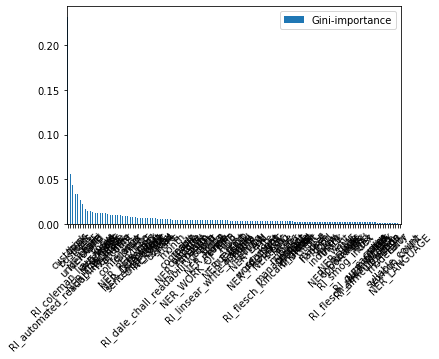

In [135]:
%matplotlib inline
feats_ = {} # a dict to hold feature_name: feature_importance
for ft, importance in zip(all_features, classifier.feature_importances_):
    feats_[ft] = importance #add the name/value pair 

importances = pd.DataFrame.from_dict(feats_, orient='index').rename(columns={0: 'Gini-importance'})
importances.sort_values(by='Gini-importance', ascending = False).plot(kind='bar', rot=45)

In [136]:
importances = classifier.feature_importances_
std = np.std([tree.feature_importances_ for tree in classifier.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(len(all_features)):
    print("%d. feature %d ----> %s (%f)" % (f + 1, indices[f], all_features[f], importances[indices[f]]))

Feature ranking:
1. feature 11 ----> word_count (0.232251)
2. feature 54 ----> char_count (0.055864)
3. feature 10 ----> avg_word (0.043669)
4. feature 45 ----> numerics (0.033583)
5. feature 123 ----> sentence_count (0.033357)
6. feature 101 ----> syllable_count (0.026276)
7. feature 125 ----> lexicon_count (0.021528)
8. feature 20 ----> RI_flesch_reading_ease (0.016585)
9. feature 130 ----> RI_smog_index (0.014783)
10. feature 44 ----> RI_flesch_kincaid_grade (0.013677)
11. feature 42 ----> RI_coleman_liau_index (0.012749)
12. feature 33 ----> RI_automated_readability_index (0.012498)
13. feature 2 ----> RI_dale_chall_readability_score (0.012345)
14. feature 27 ----> RI_difficult_words (0.012025)
15. feature 74 ----> RI_linsear_write_formula (0.011923)
16. feature 59 ----> RI_gunning_fog (0.011780)
17. feature 70 ----> NER_PERSON (0.011387)
18. feature 41 ----> NER_NORP (0.010173)
19. feature 3 ----> NER_FAC (0.009905)
20. feature 92 ----> NER_ORG (0.009766)
21. feature 38 ----> NER_

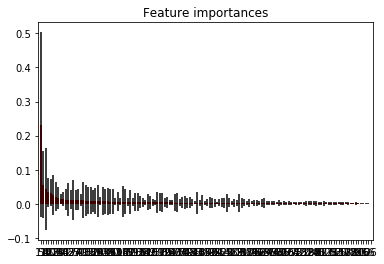

In [137]:
# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(len(all_features)), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(len(all_features)), indices)
plt.xlim([-1, len(all_features)])
plt.show()

In [138]:
# Predicting on a train dataset
predicted_train = pipeline.predict(X_train)

# Model Accuracy
print("Training MSE:",metrics.mean_squared_error(y_train, predicted_train))
print("Training RMSE:",np.sqrt(metrics.mean_squared_error(y_train, predicted_train)))

Training MSE: 0.051339667846509666
Training RMSE: 0.22658258504684262


In [139]:
# Predicting with a test dataset
predicted_test = pipeline.predict(X_test)

# Model Accuracy
print("Test MSE:",metrics.mean_squared_error(y_test, predicted_test))
print("Test RMSE:",np.sqrt(metrics.mean_squared_error(y_test, predicted_test)))

Test MSE: 0.2738181066198791
Test RMSE: 0.5232763195672809


In [140]:
pd.DataFrame({'Actuals':y_test,"predicted":predicted_test})

,Actuals,predicted
523,-0.067749,0.022347
602,-0.190724,0.035293
526,0.002736,0.036548
31,-0.037311,0.091058
616,0.025631,0.094098
...,...,...
723,0.174458,0.011305
677,0.126535,0.018032
478,0.088575,0.058466
228,0.095146,0.012490


# EDA

In [150]:
from scipy.stats import pearsonr

corr_dict = {}

for x in numeric_features:
    corr_dict[x],_  = pearsonr(y_train, X_train[x])

In [151]:
corr_dict

{'word_count': 0.05968415139890372,
 'char_count': 0.053875352589731015,
 'avg_word': 0.012284120878075103,
 'numerics': 0.10976466936885274,
 'sentence_count': 0.0902024564679002,
 'syllable_count': 0.05133798336134737,
 'lexicon_count': 0.05985591177722739,
 'RI_flesch_reading_ease': 0.03274392711347703,
 'RI_smog_index': -0.055810893866082144,
 'RI_flesch_kincaid_grade': -0.03242399934196469,
 'RI_coleman_liau_index': 0.008253358368914637,
 'RI_automated_readability_index': 0.0076824196433082715,
 'RI_dale_chall_readability_score': -0.035724039160712526,
 'RI_difficult_words': 0.027679568479764986,
 'RI_linsear_write_formula': -0.006801733215146939,
 'RI_gunning_fog': -0.03768136029870782,
 'NER_CARDINAL': 0.12375980580548923,
 'NER_DATE': 0.059948731937220834,
 'NER_GPE': -0.04539491044931325,
 'NER_LOC': -0.04709616224456088,
 'NER_MONEY': 0.03206957523363911,
 'NER_NORP': -0.0039087007165199,
 'NER_ORDINAL': 0.030240942700746877,
 'NER_ORG': 0.03446075490928279,
 'NER_PERCENT': 0

### Save Summaries as text files

In [37]:
summaries_data = pd.concat([features[["CompanyCurrentYQ","text"]],summaries], axis = 1)
summaries_data.head()

,CompanyCurrentYQ,text,summary
0,ABB-2011-1,ABB Limited First Quarter Results Conference C...,ABB Limited First Quarter Results Conference C...
1,ABB-2011-2,Transcript Page 1 Transcript Conference Call o...,Transcript Page 1 Transcript Conference Call o...
2,ABB-2011-3,Page 1 Transcript - Conference Call of ABB Lim...,Page 1 Transcript - Conference Call of ABB Lim...
3,ABB-2011-4,Page 1 of 16 “ABB Ltd’s Investor Relations & M...,Page 1 of 16 “ABB Ltd’s Investor Relations & M...
4,ABB-2012-1,“TCS Second Quarter Earnings Conference Call” ...,“TCS Second Quarter Earnings Conference Call” ...


In [36]:
#for x in range(len(summaries_data["text"])):
#    with open(os.path.join(RESULTSDIR,'processed_files','summaries','summaries',summaries_data["CompanyCurrentYQ"][x]+".txt"),'w', encoding="utf-8") as f:
#        f.write(summaries_data["summary"][x])
#    with open(os.path.join(RESULTSDIR,'processed_files','summaries','transcripts',summaries_data["CompanyCurrentYQ"][x]+".txt"),'w', encoding="utf-8") as f:
#        f.write(summaries_data["text"][x])

In [44]:
from spacy import displacy
doc = nlp(summaries_data["summary"][1000].replace("_",""))
displacy.render(doc, style = "ent", jupyter = True)

## Sentiment Analysis on Summaries

# Save processed data

In [154]:
all_data_pkl = open(os.path.join(RESULTSDIR,'processed_files','AllDataPickle'), 'ab')
pickle.dump([data,files_dict,transcripts,df,companies_info,features,summaries,NER_Output,readbility], all_data_pkl)
all_data_pkl.close()

p_data = open(os.path.join(RESULTSDIR,'processed_files','dataPickle'), 'ab')
pickle.dump(data, p_data)
p_data.close()

p_pdfs = open(os.path.join(RESULTSDIR,'processed_files','transcripts','PDFsPickle'), 'ab')
pickle.dump(files_dict, p_pdfs)
p_pdfs.close()

p_transcripts = open(os.path.join(RESULTSDIR,'processed_files','transcripts','transcriptsPickle'), 'ab')
pickle.dump(transcripts, p_transcripts)
p_transcripts.close()

p_financials = open(os.path.join(RESULTSDIR,'processed_files','financialsPickle'), 'ab') 
pickle.dump(df, p_financials)
p_financials.close()

p_meta = open(os.path.join(RESULTSDIR,'processed_files','metadataPickle'), 'ab') 
pickle.dump(companies_info, p_meta)
p_meta.close()

p_features = open(os.path.join(RESULTSDIR,'processed_files','featuresPickle'), 'ab') 
pickle.dump(features, p_features)
p_features.close()

Add:
1. Add textstat package and corresponding features [link](https://stackoverflow.com/questions/51645273/how-do-i-merge-data-with-countvectorizer-features)
2. Add embeddings as features and build simple ANN
3. Generate more features using spacy's NER (People, Places, Entities, Numbers, Percentages, Dates)
4. Generate Sentiment score for each document
5. Add Text Summarization functionality
6. EDA on important features